In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import yaml
from pathlib import Path
from neuralhydrology.utils.config import Config
from neuralhydrology.modelzoo.inputlayer import InputLayer
from IPython.display import display

def plot_sample_predictions(y, y_hat, kge=None, nse=None, title="Sample Prediction", max_plots=1):
    for i in range(min(len(y), max_plots)):
        plt.figure(figsize=(8, 4))
        plt.plot(y[i].cpu(), label="Observed")
        plt.plot(y_hat[i].cpu(), label="Predicted")
        if kge:
            plt.title(f"{title} | KGE: {kge[i]:.3f}")
        elif nse:
            plt.title(f"{title} | NSE: {nse[i]:.3f}")
        else:
            plt.title(title)
        plt.xlabel("Time Step")
        plt.ylabel("Streamflow")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

class Normalizer:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def normalize(self, x):
        return (x - self.mean) / (self.std + 1e-6)

    def denormalize(self, x):
        return x * (self.std + 1e-6) + self.mean

# Description

* This script trains the cudaLSTM from neural hydrology on the CAMELS dataset
* Some important caveats include:
* The data do not have time stamps assosciated with them
* Each training period has a sequence lenght of 366 starting on Jan. 1 and going through Jan. 1 of the following year
* This is in contrast to starting from say the beginning of the water year or providing multiple years in * a row in the training
* Data were created using 'Process_Caravan_Forecasts_hybrid_cudaLSTM_CAMELS.ipynb'
* Dynamic inputs include precipitation, 2-m temperture, u_wind 10 m, v_wind 10 m, dew_point, net_solar from ERA5 - CARAVAN
* Dynamic data are at a daily time step
* Target data is streamflow from USGA gauges in the CAMELS dataset
* Static attributes come from CAMELS data and are: 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'elev_mean', 'slope_mean', 'area_gages2', 'frac_forest', 'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability'


The model uses a:
* Regression head
* hidden_size = 64
* dropout rate = 0.3
* outout_dropout = 0.4 - might want to be lower.
* loss type of mse
* Normalizes the training data only - done in this script.
* Adam optimizer with a weight_decay. Weight decay is a form of L2 regularization. It penalizes large weights during training by adding a term to the loss function. This helps prevent overfitting by discouraging large weights. Encourages smoother, simpler models that generalize better.
* Reduces the learning rate using scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True), where mode='min' — because you're minimizing loss. factor=0.5 — reduces the LR by half. patience=5 — wait 5 epochs without improvement before reducing LR. verbose=True — prints when LR is reduced.

##### `head`: 
The head is the final layer/module of your model that transforms the LSTM (or Transformer) output into the predicted quantity. Different heads apply different logic or constraints to that transformation.

When regression head is appropriate (default):
* You want to predict a continuous value (e.g., streamflow).
* You’re optimizing something like MSE, NSE, or KGE.
* You don’t need extra constraints (e.g., non-negativity, quantiles, classification).

You want uncertainty quantification:	distribution or quantile \
Your target variable is categorical (e.g., flood stage categories):	classification \
You want multiple outputs with different objectives:	multihead \
You’re working on forecast ensembles or probabilistic outputs:	distribution, quantile \
You suspect asymmetric error behavior (e.g., overestimating peaks):	quantile or custom loss/head

##### `hidden_size`: 
The hidden_size in your model configuration reflects the dimensionality of the hidden state in the LSTM (or Transformer) layers. It determines how much information the model can store and process at each time step. Each time step in your input sequence (e.g., daily climate variables) is passed through an LSTM cell. The LSTM maintains a hidden state vector and a cell state vector. hidden_size is the length of that hidden state vector. Small datasets / fast prototyping: 16, 32 Moderate complexity: 64, 128 Larger models / more data: 256+ If your training and validation losses diverge quickly, it might mean hidden_size is too large relative to your dataset size (try reducing it or increasing regularization like dropout). In LSTM-based hydrologic models like CudaLSTM, hidden_size determines the capacity of the model to store and process information about past conditions (e.g., precipitation, temperature, snow state) that influence current and future streamflow. If you're modeling a snowmelt-dominated basin: Snowfall in November–March influences April–July runoff. The model needs a longer memory to learn the connection between early-season precipitation and late-season flow. You might want a larger hidden_size (e.g., 64 or 128) to retain those dependencies. In contrast, if you model a flashy monsoonal watershed: Streamflow spikes shortly after a storm, and drops quickly. A smaller hidden_size (e.g., 16 or 32) might be adequate because long-term memory is less important. So yes — you can and should link hidden_size to the dominant hydrologic processes of the basin(s) you're modeling. And if you’re modeling a wide variety of basins (e.g., in a regional model), using a moderate-to-large hidden_size with dropout may help balance generalization and specificity.

##### `dropout`:
This applies inside the core model layers — for CudaLSTM, that means: Between LSTM layers (if using a stacked LSTM) Between input features and LSTM. Potentially applied to embeddings or hidden states. Purpose: Regularizes the temporal modeling capacity, preventing overfitting by randomly zeroing out parts of the hidden state during training.

##### `output_droput`: 
This applies after the core model, just before the final output (the head layer): For regression: before the fully connected layer that maps to the target variable(s). For classification (e.g., for event detection): before softmax/logitsRegularizes the final predictions, especially useful when overfitting is evident near the output layer (e.g., target variables match training data well but not generalize). Typical values: Often smaller than core dropout (e.g., 0.1–0.3) Can be useful if your output layer is overconfident.


# To add:
* Batch size
* initial_forget_bias
* output_activation
* validate every?
* clip_gardient_norm?
* parallelize across GPUs?



# Real Data

In [2]:

# --- Custom Dataset ---
class CustomForecastDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets, basin_ids, static_features, forecast_dates, embedding_net=None):
        self.sequences = sequences
        self.targets = targets
        self.basin_ids = basin_ids
        self.static_features = static_features
        self.forecast_dates = forecast_dates  # <--- NEW
        self.embedding_net = embedding_net

        self.feature_names = [f"feat{i}" for i in range(sequences.shape[2])]
        first_key = next(iter(static_features))
        self.static_names = [f"static{i}" for i in range(static_features[first_key].shape[0])]
        
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x_d_tensor = self.sequences[idx]
        y = self.targets[idx]
        basin_id = self.basin_ids[idx]
        x_s_tensor = self.static_features[basin_id]

        x_d = {
            feature_name: torch.tensor(x_d_tensor[:, i]).unsqueeze(-1).float()
            for i, feature_name in enumerate(self.feature_names)
        }

        x_s = torch.tensor(x_s_tensor).float()
        if self.embedding_net is not None:
            x_s = self.embedding_net(x_s)

        y = torch.tensor(y).float()

        return {
            "x_d": x_d,
            "x_s": x_s,
            "y": y,
            "basin_id": self.basin_ids[idx],
            "forecast_date": self.forecast_dates[idx],
        }

# 🧱 Use your existing CustomForecastDataset
# ---------------------------------------
# 🗂️ Load NetCDF Data (Unstandardized)
# ---------------------------------------
train_ds = xr.open_dataset("/Projects/HydroMet/currierw/Caravan-Jan25-csv/test/train_data_ERA5_CAMELS_unstandardized.nc")
val_ds   = xr.open_dataset("/Projects/HydroMet/currierw/Caravan-Jan25-csv/test/validation_data_ERA5_CAMELS_unstandardized.nc")
test_ds   = xr.open_dataset("/Projects/HydroMet/currierw/Caravan-Jan25-csv/test/test_data_ERA5_CAMELS_unstandardized.nc")

# Extract from xarray
sequences_train = train_ds["dynamic_inputs"].values
targets_train = train_ds["targets"].values
basin_ids_train = train_ds["basin_id"].values
train_forecast_dates = train_ds["forecast_date"].values

# Compute mean/std for dynamic inputs - Compute Normalizers from Train Data Only
dyn_mean = sequences_train.mean(axis=(0, 1), keepdims=True)  # shape (1, 1, num_features)
dyn_std  = sequences_train.std(axis=(0, 1), keepdims=True)

# Compute mean/std for targets (optional but helpful for MSE)
target_mean = targets_train.mean()
target_std  = targets_train.std()

sequences_val = val_ds["dynamic_inputs"].values
targets_val = val_ds["targets"].values
basin_ids_val = val_ds["basin_id"].values
val_forecast_dates = val_ds["forecast_date"].values

sequences_test = test_ds["dynamic_inputs"].values
targets_test = test_ds["targets"].values
basin_ids_test = test_ds["basin_id"].values
test_forecast_dates = test_ds["forecast_date"].values

# # ---------------------------------------
# # Static Features
# # ---------------------------------------

static_ds = xr.open_dataset('/Projects/HydroMet/currierw/static_features_CAMELS.nc')

# Convert gauge_id values to string to match basin_ids
gauge_ids_static = static_ds["gauge_id"].values.astype(str)
static_feat_array = static_ds["static_features"].values  # shape: (n_gauges, n_features)

static_features_dict = {
    gid: static_feat_array[i]
    for i, gid in enumerate(gauge_ids_static)
}

all_static = np.stack(list(static_features_dict.values()))
static_mean = np.nanmean(all_static, axis=0)
static_std  = np.nanstd(all_static, axis=0)
static_normalizer = Normalizer(static_mean, static_std)

static_features_dict_norm = {
    k: static_normalizer.normalize(v)
    for k, v in static_features_dict.items()
}

# ---------------------------------------
# Store normalizers
# ---------------------------------------
dyn_normalizer = Normalizer(dyn_mean, dyn_std)
target_normalizer = Normalizer(target_mean, target_std)
static_normalizer = Normalizer(static_mean, static_std)

# ---------------------------------------
# Normalize the Datasets
# ---------------------------------------

# Normalize dynamic inputs and targets
sequences_train_norm = dyn_normalizer.normalize(sequences_train)
targets_train_norm   = target_normalizer.normalize(targets_train)

sequences_val_norm = dyn_normalizer.normalize(sequences_val)
targets_val_norm   = target_normalizer.normalize(targets_val)

sequences_test_norm = dyn_normalizer.normalize(sequences_test)
targets_test_norm   = target_normalizer.normalize(targets_test)

# Normalize static features dict
static_features_dict_norm = {
    k: static_normalizer.normalize(v)
    for k, v in static_features_dict.items()
}

# ---------------------------------------
# 🔧 Setup Dataset and DataLoader
# ---------------------------------------
train_dataset = CustomForecastDataset(
    sequences=sequences_train_norm,
    targets=targets_train_norm,
    basin_ids=basin_ids_train,
    static_features=static_features_dict_norm,
    forecast_dates=train_forecast_dates,
    embedding_net=None
)

val_dataset = CustomForecastDataset(
    sequences=sequences_val_norm,
    targets=targets_val_norm,
    basin_ids=basin_ids_val,
    static_features=static_features_dict_norm,
    forecast_dates=val_forecast_dates,
    embedding_net=None
)

test_dataset = CustomForecastDataset(
    sequences=sequences_test_norm,
    targets=targets_test_norm,
    basin_ids=basin_ids_test,
    static_features=static_features_dict_norm,
    forecast_dates=test_forecast_dates,
    embedding_net=None
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# ---------------------------------------
# 🔍 Check Output Shapes
# ---------------------------------------
for batch in train_loader:
    print("✅ Batch from train_loader:")
    print("x_d keys:", batch["x_d"].keys())
    print("x_d feat0 shape:", batch["x_d"]["feat0"].shape)  # (batch_size, seq_len, 1) # batch size is across samples/basins/forecasts, each uses the full sequence length, the 1 or last element is the number of target variables
    print("x_s shape:", batch["x_s"].shape)                 # (batch_size, n_static_features)
    print("y shape:", batch["y"].shape)                     # (batch_size, seq_len, 1)
    break

✅ Batch from train_loader:
x_d keys: dict_keys(['feat0', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5'])
x_d feat0 shape: torch.Size([16, 366, 1])
x_s shape: torch.Size([16, 27])
y shape: torch.Size([16, 366, 1])


# Model

In [3]:
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
class CustomCudaLSTM(CudaLSTM):
    def __init__(self, cfg):
        super().__init__(cfg)  # use the original setup including heads, dropout, etc.

# Helpers

In [4]:

def load_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

def get_loss_function(cfg):
    loss_type = cfg._cfg.get("loss_type", None)
    loss_seq_len = cfg._cfg.get("loss_seq_len", None)

    print(loss_type)
    if loss_type == "mse":
        return MSELoss(cfg._cfg.get("loss_seq_len", None))
    elif loss_type == "nse":
        return NSELoss(cfg._cfg.get("loss_seq_len", None))
    elif loss_type == "kge":
        return KGELoss(cfg._cfg.get("loss_seq_len", None))
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

# Can be used to optimize
class MSELoss(nn.Module):
    def __init__(self, seq_len=None):
        super().__init__()
        self.seq_len = seq_len

    def forward(self, y_hat, y):
        if self.seq_len:
            y_hat = y_hat[:, -self.seq_len:, :]
            y = y[:, -self.seq_len:, :]
        return torch.mean((y_hat - y) ** 2)
        
# Can be used to optimize
class NSELoss(nn.Module):
    def __init__(self, seq_len=None):
        super().__init__()
        self.seq_len = seq_len

    def forward(self, y_hat, y):
        if self.seq_len:
            y_hat = y_hat[:, -self.seq_len:, :]
            y = y[:, -self.seq_len:, :]

        mean_y = torch.mean(y, dim=1, keepdim=True)
        numerator = torch.sum((y - y_hat) ** 2, dim=1)
        denominator = torch.sum((y - mean_y) ** 2, dim=1)
        nse = 1 - (numerator / (denominator + 1e-6))  # avoid division by zero
        return -torch.mean(nse)  # minimize negative NSE
        
# Can be used to optimize
class KGELoss(nn.Module):
    def __init__(self, seq_len=None):
        super().__init__()
        self.seq_len = seq_len

    def forward(self, y_hat, y):
        if self.seq_len:
            y_hat = y_hat[:, -self.seq_len:, :]
            y = y[:, -self.seq_len:, :]

        mean_obs = torch.mean(y, dim=1, keepdim=True)
        mean_sim = torch.mean(y_hat, dim=1, keepdim=True)
        std_obs = torch.std(y, dim=1, keepdim=True)
        std_sim = torch.std(y_hat, dim=1, keepdim=True)

        # Correlation
        y_centered = y - mean_obs
        y_hat_centered = y_hat - mean_sim
        correlation = torch.sum(y_centered * y_hat_centered, dim=1) / (
            torch.sqrt(torch.sum(y_centered ** 2, dim=1)) *
            torch.sqrt(torch.sum(y_hat_centered ** 2, dim=1)) + 1e-6)

        # Alpha and Beta
        alpha = std_sim / (std_obs + 1e-6)
        beta = mean_sim / (mean_obs + 1e-6)

        kge = 1 - torch.sqrt((correlation - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
        return -torch.mean(kge)  # negative KGE for minimization

# Not used to optimize but computed on the output
def compute_kge_all(y_hat, y):
    # y_hat, y: shape [batch, seq_len]
    mean_y = y.mean(dim=1, keepdim=True)
    mean_hat = y_hat.mean(dim=1, keepdim=True)
    std_y = y.std(dim=1, keepdim=True)
    std_hat = y_hat.std(dim=1, keepdim=True)

    std_y = std_y + 1e-6
    std_hat = std_hat + 1e-6

    corr_num = torch.sum((y - mean_y) * (y_hat - mean_hat), dim=1)
    corr_den = torch.sqrt(torch.sum((y - mean_y) ** 2, dim=1)) * torch.sqrt(torch.sum((y_hat - mean_hat) ** 2, dim=1))
    corr = corr_num / (corr_den + 1e-6)

    alpha = std_hat.squeeze(1) / std_y.squeeze(1)
    beta = mean_hat.squeeze(1) / (mean_y.squeeze(1) + 1e-6)

    kge = 1 - torch.sqrt((corr - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    return kge  # shape [batch]

def compute_nse_all(y_hat, y):
    # y_hat, y: shape [batch, seq_len]
    mean_y = y.mean(dim=1, keepdim=True)
    numerator = torch.sum((y - y_hat) ** 2, dim=1)
    denominator = torch.sum((y - mean_y) ** 2, dim=1) + 1e-6
    nse = 1 - numerator / denominator
    return nse  # shape [batch]

def compute_kge_mean(y_hat, y):
    return compute_kge_all(y_hat, y).mean().item()

def compute_nse_mean(y_hat, y):
    return compute_nse_all(y_hat, y).mean().item()


# Train

In [5]:


from neuralhydrology.modelzoo.cudalstm import CudaLSTM
class CustomCudaLSTM(CudaLSTM):
    def __init__(self, cfg):
        super().__init__(cfg)  # use the original setup including heads, dropout, etc.



def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    count = 0
    kge_scores = []
    nse_scores = []

    with torch.no_grad():
        for batch in loader:
            x_d = {k: v.to(device) for k, v in batch["x_d"].items()}
            x_s = batch["x_s"].to(device)
            y = batch["y"].to(device)

            output = model({"x_d": x_d, "x_s": x_s})
            y_hat = output["y_hat"]
            
            loss = loss_fn(y_hat, y)
            total_loss += loss.item()
            count += 1
            
            # De-normalize before computing hydrology metrics
            y_hat_denorm = target_normalizer.denormalize(y_hat).squeeze(-1)
            y_denorm     = target_normalizer.denormalize(y).squeeze(-1)

            # print("Original shapes:", y_hat.shape, y.shape)
            # print("After denorm:", y_hat_denorm.shape, y_denorm.shape)
            
            # print("Example y_hat_denorm[0]:", y_hat_denorm[0, :10])
            # print("Example y_denorm[0]:", y_denorm[0, :10])
            
            kge_scores.append(compute_kge_mean(y_hat_denorm, y_denorm))
            nse_scores.append(compute_nse_mean(y_hat_denorm, y_denorm))


    avg_loss = total_loss / count if count > 0 else float("nan")
    kge_arr = torch.tensor(kge_scores)
    nse_arr = torch.tensor(nse_scores)
    
    avg_kge = torch.nanmedian(kge_arr).item()
    avg_nse = torch.nanmedian(nse_arr).item()

    print(f"📈 Eval: MSE = {avg_loss:.4f} | KGE = {avg_kge:.4f} | NSE = {avg_nse:.4f}")
    return avg_loss

def train_model(cfg, model, train_loader, val_loader, loss_fn, optimizer):
    device = torch.device(cfg._cfg.get("device"))
    model.to(device)

    best_val_loss = float("inf")
    
    total_train_loss = 0.0
    train_batches = 0
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    for epoch in range(1, cfg._cfg.get("num_epochs") + 1):
        model.train()
        for batch in train_loader:
            x_d = {k: v.to(device) for k, v in batch["x_d"].items()}
            x_s = batch["x_s"].to(device)
            y   = batch["y"].to(device)

            output = model({"x_d": x_d, "x_s": x_s})
            y_hat = output["y_hat"]
            
            loss = loss_fn(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            train_batches += 1
            
        if epoch % cfg._cfg.get("report_every", 1) == 0:
            avg_train_loss = total_train_loss / train_batches
            val_loss = evaluate(model, val_loader, loss_fn, device)
            scheduler.step(val_loss)
            
            print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f} | Validation Loss = {val_loss:.4f}")
            
            if cfg._cfg.get("plot_samples", 0) > 0:
                with torch.no_grad():
                    batch = next(iter(val_loader))
                    x_d = {k: v.to(device) for k, v in batch["x_d"].items()}
                    x_s = batch["x_s"].to(device)
                    y   = batch["y"].to(device)

                    out = model({"x_d": x_d, "x_s": x_s})
                    y_hat = out["y_hat"]
            
                    plot_sample_predictions(y, y_hat, n_samples=cfg._cfg.get("plot_samples"))

            if cfg._cfg.get("save_best_model", False) and val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_model.pt")
                print("✅ Saved new best model")

import matplotlib.pyplot as plt




# ----------------------------
# 🚀 Entry Point
# ----------------------------
if __name__ == "__main__":
    cfg_dict = {
        "model": "cudalstm",
        "head": "regression",          # or other supported head types
        "hidden_size": 64,
        "dropout": 0.3,
        "loss_seq_len": 366,
        "target_variables": ["Q"],
        "learning_rate": 1e-3,
        "device": "cuda",
        "output_dropout": 0.4,
        "num_epochs":50,
        "dynamic_inputs": ['feat0', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5'],  # <<<<< REQUIRED by CudaLSTM/InputLayer
        "static_attributes": ['p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow',
    'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur',
    'elev_mean', 'slope_mean', 'area_gages2',
    'frac_forest', 'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff',
    'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity',
    'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
    'carbonate_rocks_frac', 'geol_permeability'],  # optional but often present
        "loss_type": "mse",   # or "nse"
        "report_every": 1,
        "plot_samples": 0,
        "save_best_model": True
    }
            
    cfg = Config(cfg_dict, dev_mode=True)  # 👈 this fixes the issue

    # train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    # val_loader = DataLoader(val_data, batch_size=16)
    # test_loader = DataLoader(test_data, batch_size=16)

    model = CustomCudaLSTM(cfg)
    loss_fn = get_loss_function(cfg)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg._cfg.get("learning_rate"), weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    train_model(cfg, model, train_loader, val_loader, loss_fn, optimizer)


mse


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


📈 Eval: MSE = 0.6056 | KGE = 0.1766 | NSE = -0.5809
Epoch 1: Train Loss = 0.6165 | Validation Loss = 0.6056
✅ Saved new best model
📈 Eval: MSE = 0.5275 | KGE = 0.2799 | NSE = -0.1252
Epoch 2: Train Loss = 0.5503 | Validation Loss = 0.5275
✅ Saved new best model
📈 Eval: MSE = 0.4755 | KGE = 0.2755 | NSE = -0.1686
Epoch 3: Train Loss = 0.5119 | Validation Loss = 0.4755
✅ Saved new best model
📈 Eval: MSE = 0.4501 | KGE = 0.2968 | NSE = -0.1316
Epoch 4: Train Loss = 0.4843 | Validation Loss = 0.4501
✅ Saved new best model
📈 Eval: MSE = 0.4242 | KGE = 0.3390 | NSE = -0.0123
Epoch 5: Train Loss = 0.4641 | Validation Loss = 0.4242
✅ Saved new best model
📈 Eval: MSE = 0.4069 | KGE = 0.2579 | NSE = -0.0603
Epoch 6: Train Loss = 0.4485 | Validation Loss = 0.4069
✅ Saved new best model
📈 Eval: MSE = 0.3988 | KGE = 0.3276 | NSE = 0.0099
Epoch 7: Train Loss = 0.4353 | Validation Loss = 0.3988
✅ Saved new best model
📈 Eval: MSE = 0.3900 | KGE = 0.2569 | NSE = -0.1305
Epoch 8: Train Loss = 0.4243 | V

✅ Loaded best model for testing
🧪 Test MSE: 0.3749
🔝 Best KGE values: [0.9784501194953918, 0.9567258358001709, 0.9542221426963806, 0.9502868056297302, 0.941510796546936, 0.9369698166847229, 0.9367504715919495, 0.9323301315307617, 0.9319390654563904, 0.9285417199134827]
🔻 Worst KGE values: [-108.89740753173828, -127.10502624511719, -188.31573486328125, -213.46926879882812, -221.7825469970703, -701.3269653320312, -2396.993896484375, -142109.796875, -166670.625, -234563.875]
✅ Best Prediction 1259: Gauge ID = 13240000, Name = LAKE FORK PAYETTE RIVER AB JUMBO CR NR MCCALL ID, Date = 2009-01-01


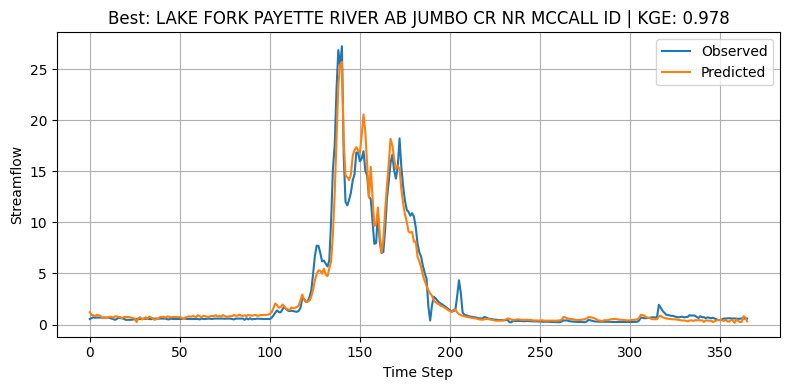

✅ Best Prediction 659: Gauge ID = 06043500, Name = Gallatin River near Gallatin Gateway MT, Date = 2010-01-01


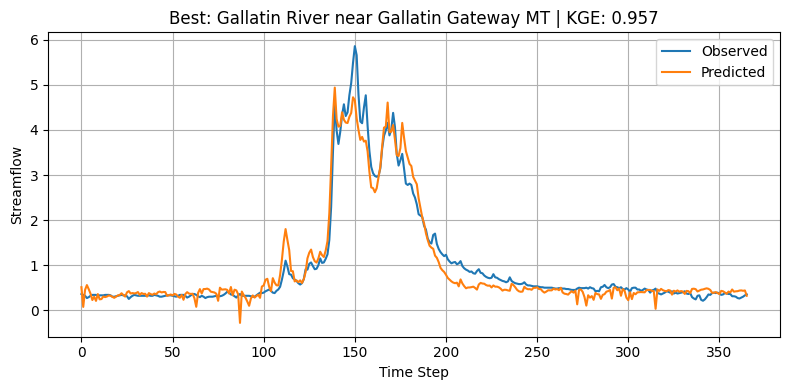

✅ Best Prediction 1211: Gauge ID = 12175500, Name = THUNDER CREEK NEAR NEWHALEM, WA, Date = 2009-01-01


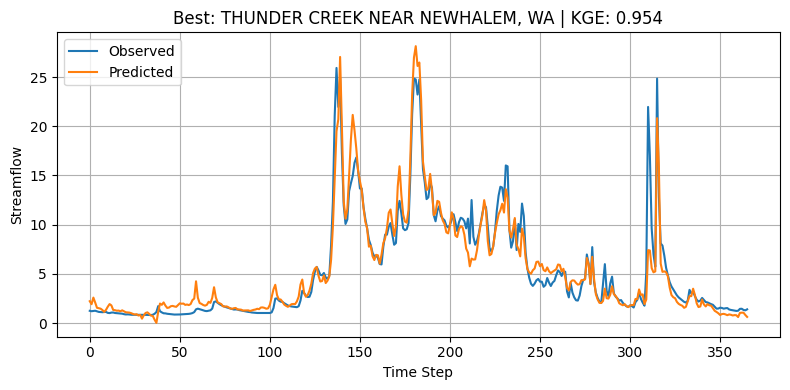

✅ Best Prediction 1324: Gauge ID = 14306500, Name = ALSEA RIVER NEAR TIDEWATER, OR, Date = 2010-01-01


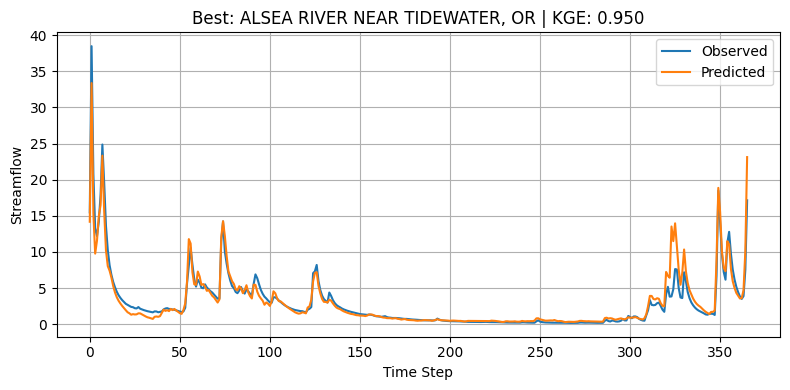

✅ Best Prediction 1147: Gauge ID = 11482500, Name = REDWOOD C A ORICK CA, Date = 2009-01-01


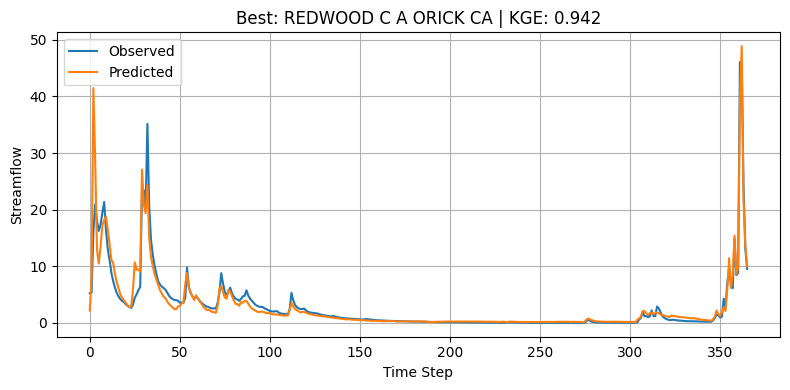

✅ Best Prediction 1226: Gauge ID = 12377150, Name = Mission Cr ab Reservoir nr ST Ignatius MT, Date = 2010-01-01


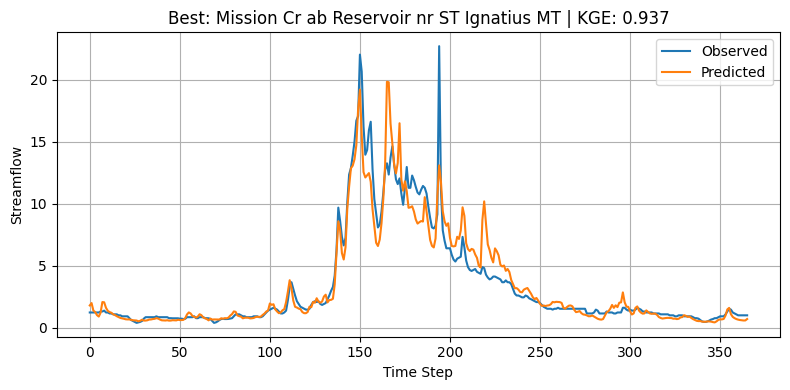

✅ Best Prediction 969: Gauge ID = 09034900, Name = BOBTAIL CREEK NEAR JONES PASS, CO., Date = 2010-01-01


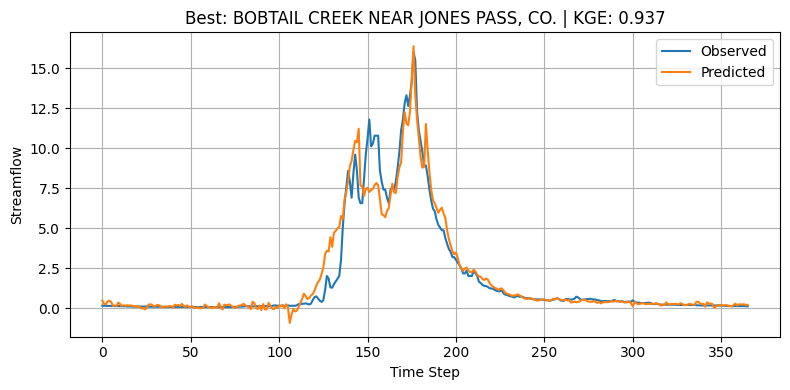

✅ Best Prediction 1273: Gauge ID = 13340600, Name = NF CLEARWATER RIVER NR CANYON RANGER STATION ID, Date = 2009-01-01


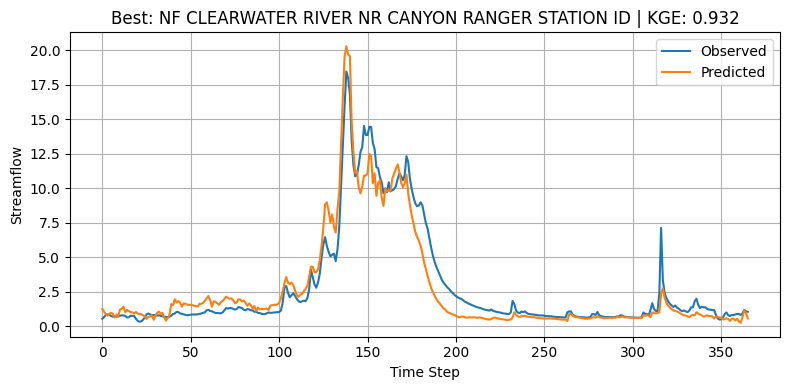

✅ Best Prediction 745: Gauge ID = 06746095, Name = JOE WRIGHT CREEK ABOVE JOE WRIGHT RESERVOIR, CO., Date = 2010-01-01


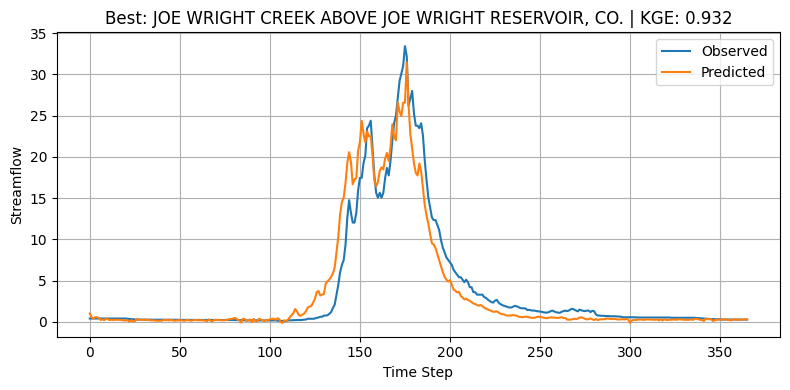

✅ Best Prediction 977: Gauge ID = 09065500, Name = GORE CREEK AT UPPER STATION, NEAR MINTURN, CO., Date = 2010-01-01


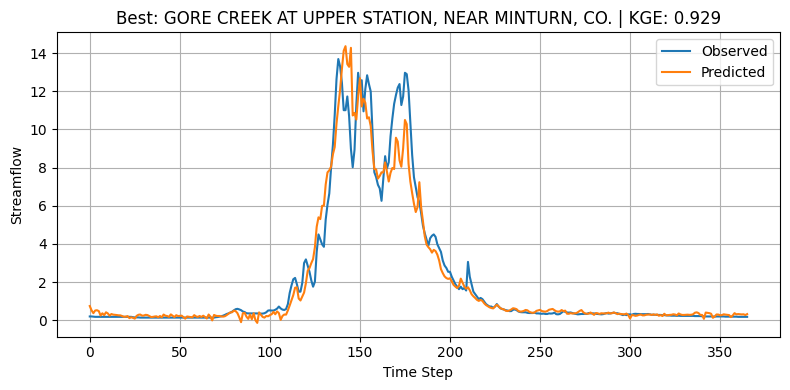

❌ Worst Prediction 584: Gauge ID = 05120500, Name = WINTERING RIVER NR KARLSRUHE, ND, Date = 2009-01-01


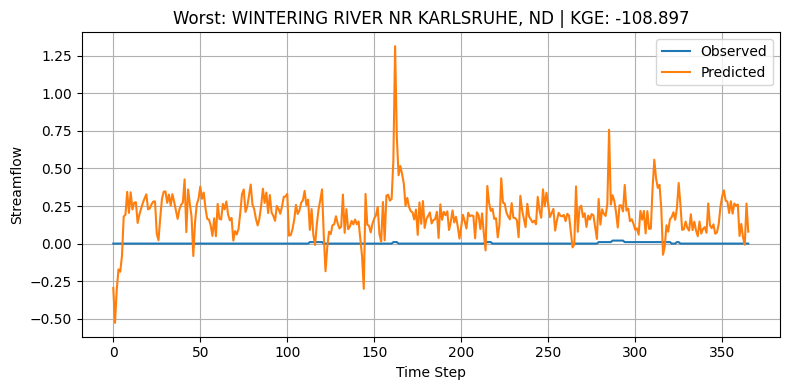

❌ Worst Prediction 684: Gauge ID = 06344600, Name = GREEN RIVER NR NEW HRADEC, ND, Date = 2009-01-01


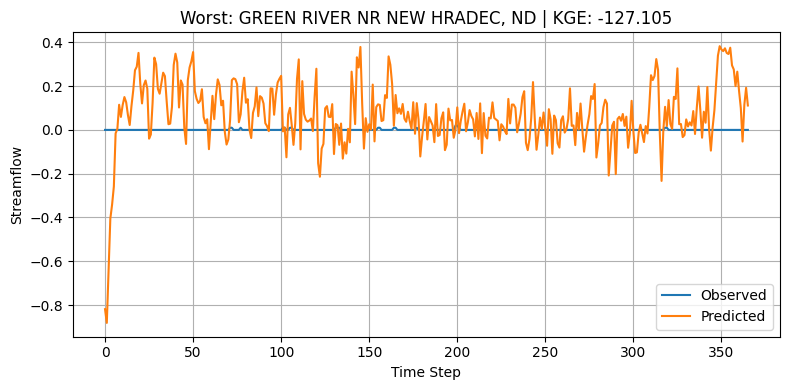

❌ Worst Prediction 586: Gauge ID = 05123400, Name = WILLOW CREEK NR WILLOW CITY, ND, Date = 2009-01-01


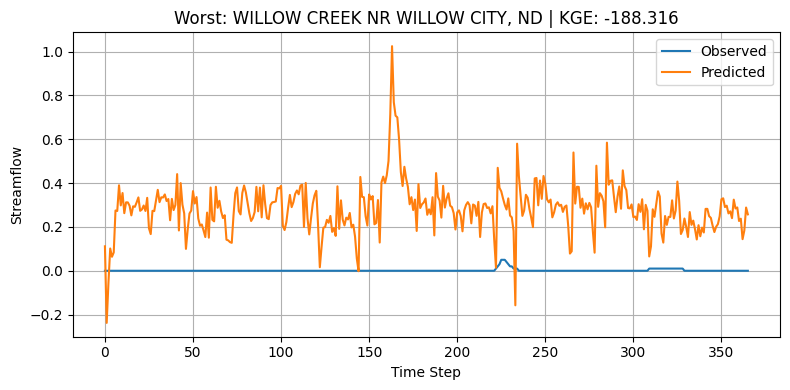

❌ Worst Prediction 949: Gauge ID = 08198500, Name = Sabinal Rv at Sabinal, TX, Date = 2010-01-01


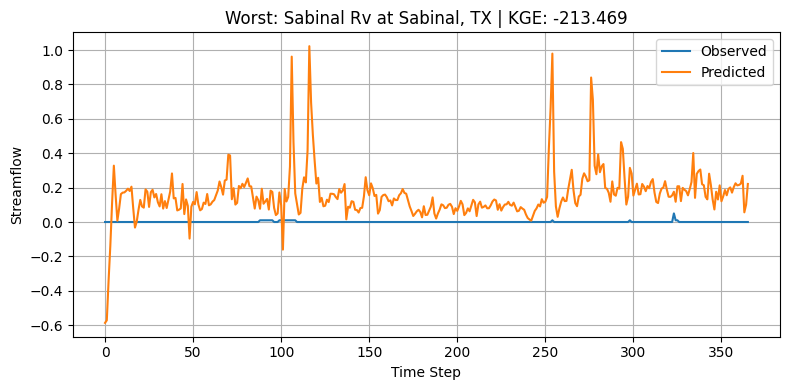

❌ Worst Prediction 940: Gauge ID = 08190500, Name = W Nueces Rv nr Brackettville, TX, Date = 2009-01-01


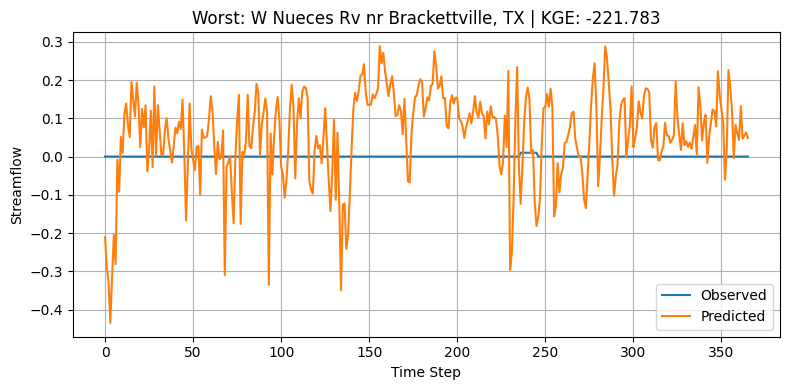

❌ Worst Prediction 1017: Gauge ID = 09484600, Name = PANTANO WASH NEAR VAIL, AZ., Date = 2010-01-01


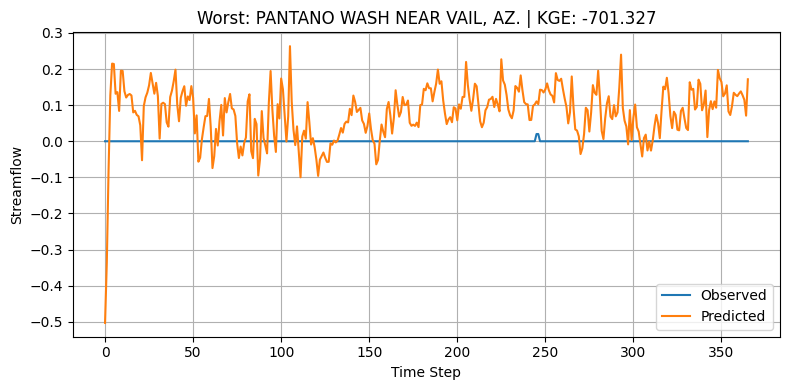

❌ Worst Prediction 678: Gauge ID = 06332515, Name = BEAR DEN CREEK NR MANDAREE, ND, Date = 2009-01-01


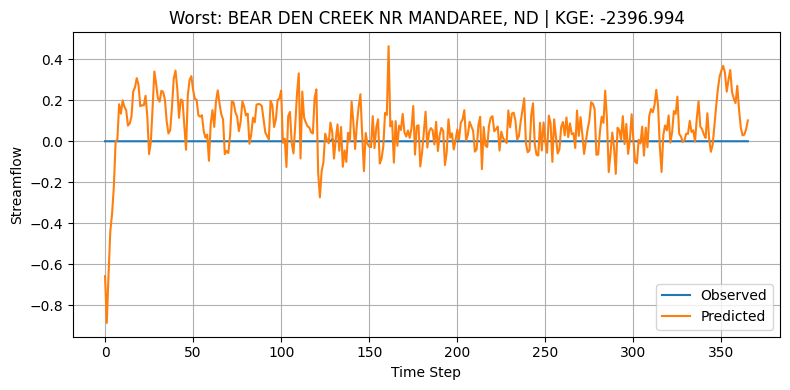

❌ Worst Prediction 941: Gauge ID = 08190500, Name = W Nueces Rv nr Brackettville, TX, Date = 2010-01-01


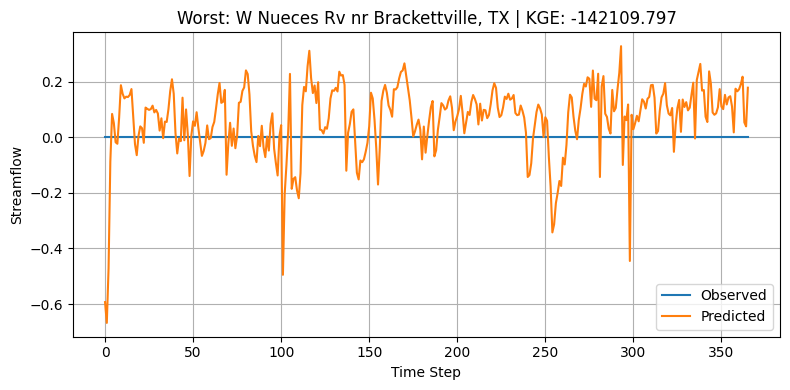

❌ Worst Prediction 952: Gauge ID = 08202700, Name = Seco Ck at Rowe Ranch nr D'Hanis, TX, Date = 2009-01-01


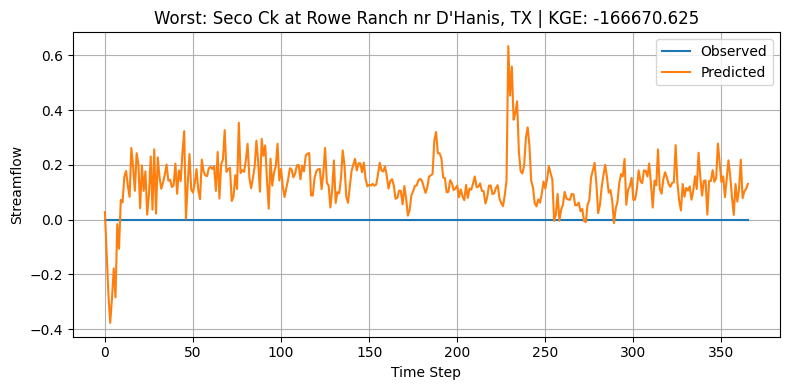

❌ Worst Prediction 953: Gauge ID = 08202700, Name = Seco Ck at Rowe Ranch nr D'Hanis, TX, Date = 2010-01-01


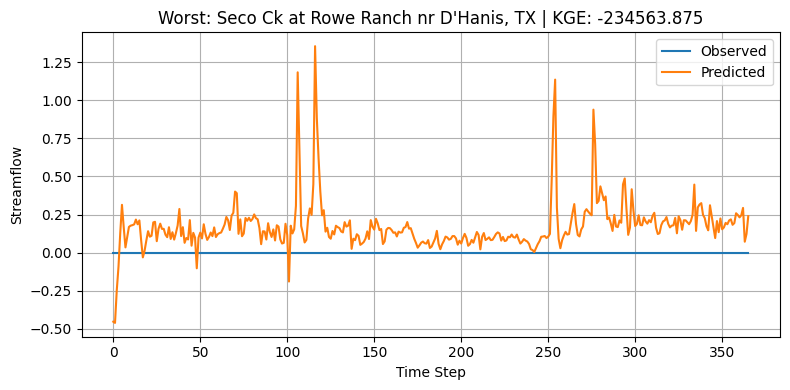

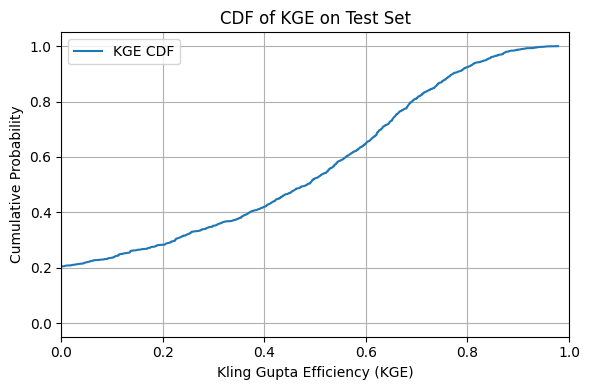

0.37493040934315924

In [11]:
import pandas as pd
df_NAME=pd.read_csv('/Projects/HydroMet/currierw/CAMELS_US/camels_name.txt',header=0,delimiter=';')
def get_gauge_name(gauge_id,df_NAME):
    row = df_NAME[df_NAME["gauge_id"] == int(gauge_id)]
    if not row.empty:
        return row.iloc[0]["gauge_name"]
    else:
        return "Unknown"


def test_model(cfg, model, test_loader, loss_fn):
    device = torch.device(cfg._cfg.get("device"))
    model.to(device)

    if Path("best_model.pt").exists():
        model.load_state_dict(torch.load("best_model.pt"))
        print("✅ Loaded best model for testing")

    model.eval()
    total_loss = 0.0
    count = 0

    all_kge = []
    all_nse = []
    all_y = []
    all_y_hat = []
    all_dates = []
    all_basins = []

    with torch.no_grad():
        for batch in test_loader:
            x_d = {k: v.to(device) for k, v in batch["x_d"].items()}
            x_s = batch["x_s"].to(device)
            y = batch["y"].to(device)
            output = model({"x_d": x_d, "x_s": x_s})
            y_hat = output["y_hat"]
            loss = loss_fn(y_hat, y)
            total_loss += loss.item()
            count += 1

            # Denormalize and squeeze
            y_hat_denorm = target_normalizer.denormalize(y_hat).squeeze(-1)  # shape: [batch, seq]
            y_denorm     = target_normalizer.denormalize(y).squeeze(-1)      # shape: [batch, seq]

            # Store for later analysis
            all_y.append(y_denorm.cpu())
            all_y_hat.append(y_hat_denorm.cpu())

            all_kge.extend(compute_kge_all(y_hat_denorm, y_denorm).cpu().tolist())
            all_nse.extend(compute_nse_all(y_hat_denorm, y_denorm).cpu().tolist())

            all_dates.extend(batch["forecast_date"])
            all_basins.extend(batch["basin_id"])

    avg_loss = total_loss / count if count > 0 else float("nan")
    print(f"🧪 Test MSE: {avg_loss:.4f}")

    # Stack predictions
    all_y = torch.cat(all_y, dim=0)
    all_y_hat = torch.cat(all_y_hat, dim=0)
    all_kge = torch.tensor(all_kge)

    # Find best and worst 10 predictions by KGE
    sorted_indices = torch.argsort(all_kge, descending=True)
    best_indices = sorted_indices[:10]
    worst_indices = sorted_indices[-10:]

    print("🔝 Best KGE values:", all_kge[best_indices].tolist())
    print("🔻 Worst KGE values:", all_kge[worst_indices].tolist())

    for i in best_indices:
        gauge_id = all_basins[i]
        gauge_name = get_gauge_name(gauge_id,df_NAME)
        print(f"✅ Best Prediction {i}: Gauge ID = {gauge_id}, Name = {gauge_name}, Date = {all_dates[i]}")
        plot_sample_predictions(all_y[i:i+1], all_y_hat[i:i+1], [all_kge[i].item()], [], title=f"Best: {gauge_name}")
    
    for i in worst_indices:
        gauge_id = all_basins[i]
        gauge_name = get_gauge_name(gauge_id,df_NAME)
        print(f"❌ Worst Prediction {i}: Gauge ID = {gauge_id}, Name = {gauge_name}, Date = {all_dates[i]}")
        plot_sample_predictions(all_y[i:i+1], all_y_hat[i:i+1], [all_kge[i].item()], [], title=f"Worst: {gauge_name}")

    # Plot KGE CDF
    plt.figure(figsize=(6, 4))
    sorted_kge = torch.sort(all_kge)[0].numpy()
    cdf = np.arange(1, len(sorted_kge)+1) / len(sorted_kge)
    plt.plot(sorted_kge, cdf, label="KGE CDF")
    plt.xlabel("Kling Gupta Efficiency (KGE)")
    plt.ylabel("Cumulative Probability")
    plt.title("CDF of KGE on Test Set")
    plt.xlim([0,1])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return avg_loss

test_model(cfg, model, test_loader, loss_fn)

In [ ]:
# test_model(cfg, model, test_loader, loss_fn)

✨ Fine-Tuning and Flexibility
You can load saved weights using model.load_state_dict() for fine-tuning.

You can inject static attributes for a new basin without needing calendar-aware data.

You can use quantile regression or MLP heads by simply modifying config.